In [1]:
print("hello")

hello


In [46]:
model_path = r"../posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite"

body_parts = [ 
    "NOSE",
    "LEFT_EYE",
    "RIGHT_EYE",
    "LEFT_EAR",
    "RIGHT_EAR",
    "LEFT_SHOULDER",
    "RIGHT_SHOULDER",
    "LEFT_ELBOW",
    "RIGHT_ELBOW",
    "LEFT_WRIST",
    "RIGHT_WRIST",
    "LEFT_HIP",
    "RIGHT_HIP",
    "LEFT_KNEE",
    "RIGHT_KNEE",
    "LEFT_ANKLE",
    "RIGHT_ANKLE"
]

In [47]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load Videos

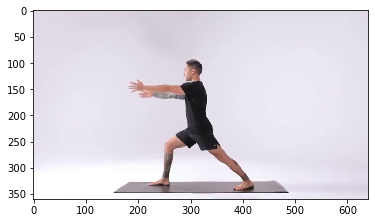

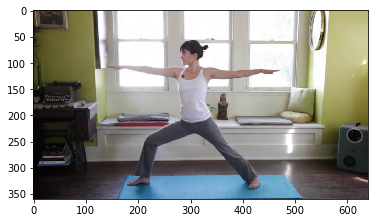

In [113]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

cap_ref = cv2.VideoCapture('ref_3.mp4')
cap_pat = cv2.VideoCapture('pat_3.mp4')

count = 0

def show_frame(cap):
    plt.figure()
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(gray, 'gray')
    return gray
        
frame_1 = show_frame(cap_ref)
frame_2 = show_frame(cap_pat)

# Get Pose

In [159]:
input_shape = tuple(input_details[0]['shape'][1:-1])

def scale(img):
    return cv2.resize(img, input_shape)
    
def preprocess(img):
    # scale to [-1, 1]
    adjust_range = np.vectorize(lambda x: (x - 128)/128)
    scaled = scale(img)
    scaled_normalized = adjust_range(scaled)
    input_as_tensor = tf.convert_to_tensor(scaled_normalized.reshape(1, *scaled_normalized.shape), np.float32)
    return input_as_tensor
    
def run_frame(img):
    interpreter.set_tensor(input_details[0]['index'], preprocess(img))
    interpreter.invoke()
    
    heatmap = interpreter.get_tensor(output_details[0]['index'])
    offsets = interpreter.get_tensor(output_details[1]['index'])

    return heatmap, offsets

def estimate_pose(img):
    scaled = scale(img)
    heatmap, offsets = run_frame(img)
    num_keypoints = heatmap.shape[-1]
    img_height, img_width = scaled.shape[:-1]
    
    df = pd.DataFrame(index=body_parts, columns=['x', 'y', 'confidence'])
    for keypoint in range(num_keypoints):
        heatmap_for_keypoint = heatmap[0,:,:,keypoint]

        # Get index of max coords from heatmap
        i, j = np.unravel_index(heatmap_for_keypoint.argmax(), heatmap_for_keypoint.shape)

        sigmoid = lambda x: 1/(1 + np.exp(-x)) 
        confidence = sigmoid(heatmap[0, i, j, keypoint])

        y = i / (heatmap.shape[1] - 1) * img_height + offsets[0,i,j,keypoint]
        x = j / (heatmap.shape[2] - 1) * img_width + offsets[0,i,j,keypoint+num_keypoints]

        y = int(y)
        x = int(x)

        body_part = body_parts[keypoint]
        df.loc[body_part] = (x, y, confidence)
        
    return df

def display(img, conf=0.5, *args, **kwargs):
    scaled = scale(img)
    df = estimate_pose(img)
    
    plt.figure(*args, **kwargs)
    plt.imshow(scaled)
    for idx, row in df.iterrows():
        if row.confidence > conf:
            plt.scatter(row.x, row.y)

In [115]:
import pandas as pd

ref_df = estimate_pose(frame_1)
pat_df = estimate_pose(frame_2)

In [126]:
ref_df

,x,y,confidence
NOSE,112,80,0.914446
LEFT_EYE,115,80,0.849831
RIGHT_EYE,113,77,0.38338
LEFT_EAR,123,83,0.737513
RIGHT_EAR,116,80,0.0731287
LEFT_SHOULDER,124,100,0.988011
RIGHT_SHOULDER,117,102,0.915047
LEFT_ELBOW,120,113,0.543971
RIGHT_ELBOW,111,109,0.615698
LEFT_WRIST,89,108,0.753888


In [125]:
pat_df

,x,y,confidence
NOSE,115,60,0.968654
LEFT_EYE,118,57,0.967204
RIGHT_EYE,113,57,0.898046
LEFT_EAR,125,60,0.84524
RIGHT_EAR,110,60,0.287631
LEFT_SHOULDER,133,80,0.944929
RIGHT_SHOULDER,112,78,0.708937
LEFT_ELBOW,152,84,0.87433
RIGHT_ELBOW,98,86,0.932662
LEFT_WRIST,173,80,0.646506


# Get Center

In [145]:
conf_threshold = 0.7

conf_1 = (pat_df[['confidence']].values > conf_threshold).astype(int)
conf_2 = (ref_df[['confidence']].values > conf_threshold).astype(int)

fields_with_confidence_intersect = (conf_1 * conf_2).reshape(-1).astype(bool)

pat_with_confidence_intersect = pat_df[fields_with_confidence_intersect]
ref_with_confidence_intersect = ref_df[fields_with_confidence_intersect]

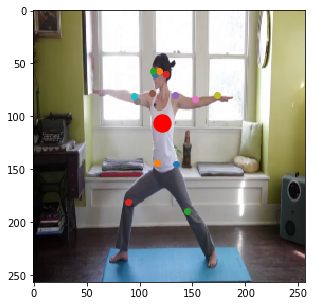

In [162]:
display(frame_2, figsize=(5,5))
x = np.sum(pat_with_confidence_intersect.x) / pat_with_confidence_intersect.shape[0]
y = np.sum(pat_with_confidence_intersect.y) / pat_with_confidence_intersect.shape[0]

plt.scatter(x, y, s=300, c='r')

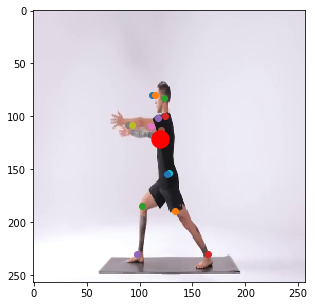

In [190]:
display(frame_1, figsize=(5,5))

x = np.sum(ref_with_confidence_intersect.x) / pat_with_confidence_intersect.shape[0]
y = np.sum(ref_with_confidence_intersect.y) / pat_with_confidence_intersect.shape[0]

plt.scatter(x, y, s=300, c='r')

In [184]:
def get_confidence_intersect(df, ref, thr=0.7):
    conf_1 = (df[['confidence']].values > conf_threshold).astype(int)
    conf_2 = (ref[['confidence']].values > conf_threshold).astype(int)

    return (conf_1 * conf_2).reshape(-1).astype(bool)

def get_diff(df, ref):
    fields_with_confidence_intersect = get_confidence_intersect(df, ref)
    df_with_confidence_intersect = df[fields_with_confidence_intersect]
    ref_with_confidence_intersect = ref[fields_with_confidence_intersect]
    
    x1 = np.sum(df_with_confidence_intersect.x) / df_with_confidence_intersect.shape[0]
    y1 = np.sum(df_with_confidence_intersect.y) / df_with_confidence_intersect.shape[0]
    x2 = np.sum(ref_with_confidence_intersect.x) / df_with_confidence_intersect.shape[0]
    y2 = np.sum(ref_with_confidence_intersect.y) / df_with_confidence_intersect.shape[0]
    return (x2-x1, y2-y1)

In [175]:
get_diff(pat_df, ref_df)

(2.125, -15.375)

# Update Positions

In [191]:
dx, dy = get_diff(pat_df, ref_df)
print(dx, dy)
pat_df_updated = pat_df.copy()

pat_df_updated.x = pat_df_updated.x + dx
pat_df_updated.y = pat_df_updated.y + dy

get_diff(pat_df_updated, ref_df)

-2.125 15.375


(0.0, 0.0)

In [185]:
indices = get_confidence_intersect(pat_df, ref_df)

mse = ((ref_df[indices][['x', 'y']] - pat_df_updated[indices][['x', 'y']])**2).mean(axis=1)

mse

NOSE               11.078125
LEFT_EYE           29.453125
LEFT_EAR           29.078125
LEFT_SHOULDER      34.328125
RIGHT_SHOULDER     62.578125
LEFT_HIP           27.828125
LEFT_KNEE         166.953125
RIGHT_KNEE        179.078125
dtype: float64

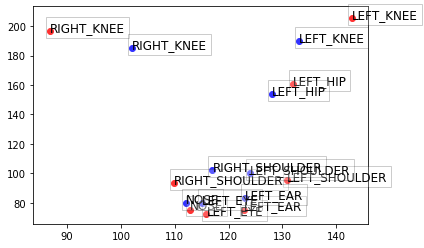

In [193]:
plt.figure()

for idx, row in pat_df_updated[indices].iterrows():
    plt.scatter(row.x, row.y, c='r')
    plt.text(row.x, row.y, idx, bbox=dict(facecolor='white', alpha=0.2), fontsize=12)
    
for idx, row in ref_df[indices].iterrows():
    plt.scatter(row.x, row.y, c='b')
    plt.text(row.x, row.y, idx, bbox=dict(facecolor='white', alpha=0.2), fontsize=12)

# Scale

...

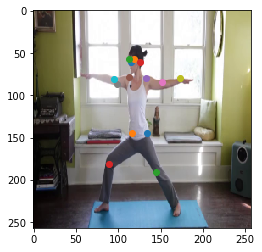

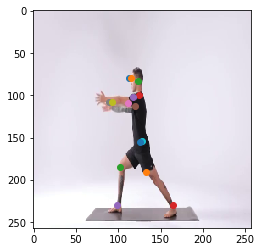

In [177]:
display(frame_2)
display(frame_1)